### Imports and data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np

df_co2 = pd.read_csv("data/data_preprocessed/CO2.csv") #ppm
df_ch4 = pd.read_csv("data/data_preprocessed/CH4.csv") #ppb
df_n2o = pd.read_csv("data/data_preprocessed/N2O.csv") #ppb

df_tmp = pd.read_csv("data/data_preprocessed/temperature.csv")

## Model using Gaussian distribution

In [2]:
from scipy import stats

normality_test = stats.normaltest(np.array(df_tmp['Anomaly']))

# Wyświetlanie wyników testu
print("Statystyka testu: ", normality_test.statistic)
print("Wartość p-wartości: ", normality_test.pvalue)

# Sprawdzenie interpretacji wyników testu
alpha = 0.05
if normality_test.pvalue < alpha:
    print("Dane nie pochodzą z rozkładu normalnego")
else:
    print("Dane są zgodne z rozkładem normalnym")

Statystyka testu:  3.3440751699526974
Wartość p-wartości:  0.18786388675829657
Dane są zgodne z rozkładem normalnym


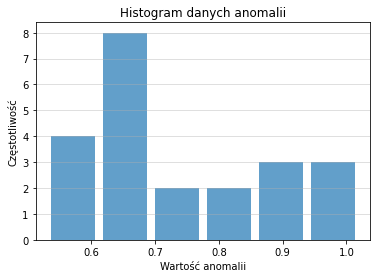

In [3]:
plt.hist(np.array(df_tmp['Anomaly']), bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Wartość anomalii')
plt.ylabel('Częstotliwość')
plt.title('Histogram danych anomalii')
plt.show()